In [1]:
import pandas as pd
import numpy as np
import os
from collections import defaultdict
from zipfile import ZipFile
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [10,10]

# Data loading and preprocessing
The accelerometer data is loaded and rotated using the rotation vector-data. PCA is employed to correct the way in which the rotation makes moving into different directions look different. Features in both time and frequency domain are calculated to allow for classification using traditional approaches.

The procedure follows "_Robust Human Activity Recognition Using Smartphone Sensors via CT-PCA and Online SVM_"  by Chen et al. 2017

In [2]:
data = defaultdict(dict)
data_dir = "./data"
for file in os.listdir(data_dir):
    if ".zip" in file:
        category, date = os.path.splitext(file)[0].split("_")
        zip_ = ZipFile(os.path.join(data_dir, file))
        for csv in zip_.namelist():
            csv_data = pd.read_csv(zip_.open(csv), index_col = False)
            ## the indexing is neat but kinda hard to read, rather than make it more easy to read I'll explain it :D
            ## if there is "_" in the column header it means that its named in the 
            ## deprecated acc_x, rot_x, etc... fashion instead of just the axis label
            ## the update is made based on splitting the column header by "_"
            ## the axis-label can be fetched by getting the second entry if there is an "_" in the header
            ## (index True/1)
            ## if the header is already in the correct format the split results is a list of one and the 
            ## first element (index False/0) is the whole header
            csv_data.rename(columns = {col : col.split("_")["_" in col].strip() for col in csv_data.columns},
                            inplace = True)
            csv_data.set_index("time", inplace = True)
            csv_data.sort_index(inplace = True)
            
            data[category + "_" + date][os.path.splitext(csv)[0]] = csv_data
            


In [3]:
## this data is from a trip to the supermarket and I forgot to stop the recording until I was already in :D, so I throw away 5 min
data["bike_1"]["acc"]=data["bike_1"]["acc"][ : 30_000]
data["bike_1"]["rot"]=data["bike_1"]["rot"][ : 30_000]

In [4]:
for key in data:
    data[key]["acc"] = data[key]["acc"].iloc[ : : 5, : ]

In [5]:
for key in data:
    for dset in data[key].values():
        dset.rename(columns = {col : col.split("_")[1].strip() for col in dset.columns if "_" in col}, inplace = True)
        if dset.index[0] >= 10e10:
            dset.index //= 1_000_000

In [6]:
def do_pca(df):
    xy = df.iloc[:, : 2]
    vals, vecs = np.linalg.eig(xy.cov())
    result = pd.DataFrame(columns = df.columns, index = df.index)
    pca = vecs[:,np.argsort(-vals)].T.dot(xy.T)
    result.loc[:, "x"], result.loc[:, "y"] = pca
    result.loc[:, "z"] = df.iloc[:, 2]
    return result

In [7]:
from bisect import bisect
def rotate_acc_data(data):
    rot_data = data["rot"].copy()
    acc_data = data["acc"].copy()
    rot_data = rot_data.groupby(rot_data.index//50).mean()
    
    acc_data = acc_data.groupby(acc_data.index//50).mean()
        
    def rotate(row):
        loc = bisect(rot_data.index, row.name)
        b,c,d,a = rot_data.iloc[min(loc, len(rot_data)-1)]
        rot_mat = np.array(
        [[1 - 2*c*c - 2*d*d, 2*b*c - 2*a*d,        2*b*d + 2*a*c],
         [ 2*b*c + 2*a*d,    1 - 2*b*b - 2*d*d,  2*c*d - 2*a*d],
         [ 2*b*d - 2*a*c,     2*c*d + 2*a*d,      1 - 2*b*b - 2*c*c]]
        )
        return rot_mat.dot(row.values)
    result = acc_data.apply(rotate, 1, result_type = "expand")
    result.columns = acc_data.columns
    return result

In [1]:
WINDOW_SIZE = 5
FREQUENCY = 20

In [9]:
from numpy.fft import fft
def get_features(df):
    df = df.copy()
    ws = WINDOW_SIZE * FREQUENCY
    result = pd.DataFrame()
    df.columns = [col.strip() for col in df.columns]
    for i in range(0, len(df) - ws, ws // 2):
        window  = do_pca(df[i : i + ws])
        fwindow =  pd.DataFrame({"x": fft(window.loc[:, "x"]).real, 
                                               "y": fft(window.loc[:, "y"]).real, 
                                               "z": fft(window.loc[:, "z"]).real})
        row = {}
        row.update({"mean_" + c: window[c].abs().mean() for c in ("x", "y", "z")})
        row.update({"variance_" + c: window[c].var() for c in ("x", "y", "z")})
        row.update({"min_" + c: window[c].min() for c in ("x", "y", "z")})
        row.update({"max_" + c: window[c].max() for c in ("x", "y", "z")})
        row.update({"range_" + c: window[c].max() - window[c].min() for c in ("x", "y", "z")})
        row.update({"MAD_" + c: (window[c] - window[c].mean()).abs().median() for c in ("x", "y", "z")})
        row.update({"power_" + c: (window[c]**2).mean() for c in ("x", "y", "z")})
        row.update({"IQR_" + c: window[c].quantile(.75) - window[c].quantile(.25) for c in ("x", "y", "z")})
        row.update({"fmean_" + c: fwindow[c].mean() for c in ("x", "y", "z")})
        row.update({"fmax_" + c: fwindow[c].max() for c in ("x", "y", "z")})
        row.update({"fskew_" + c: fwindow[c].skew() for c in ("x", "y", "z")})
        row.update({"fkurt_" + c: fwindow[c].kurt() for c in ("x", "y", "z")})
        row.update({"fpower_" + c: (fwindow[c]**2).mean() for c in ("x", "y", "z")})  
        
        result = result.append(row, ignore_index = True)
    return result

For the neural network the data isn't broken down into features and is instead just chunked into 5-second epochs.

In [17]:
def chunk(df, class_):
    ws = WINDOW_SIZE * FREQUENCY
    result = []
    df.columns = [col.strip() for col in df.columns]
    
    for i in range(0, len(df) - ws, ws // 2):
        window = do_pca(df[i : i + ws])
        result.append({"X": window, "y": class_})
    return result[:-1]

In [11]:
rot_data = {}
for key in data:    
    rot = rotate_acc_data(data[key])
    rot.to_csv(f"rotated_data/{key}.csv")
    rot_data[key] = rot

# Figures of the different activities accelerometer data

## Idle

<AxesSubplot:xlabel='time'>

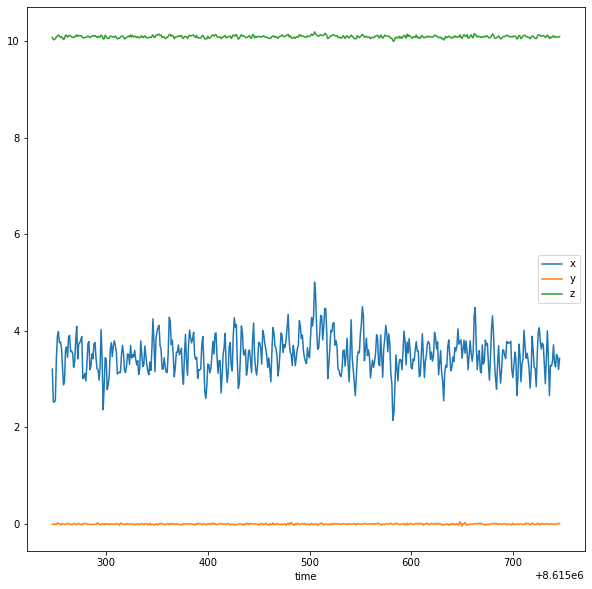

In [12]:
do_pca(rot_data["idle_1"].iloc[1500:2000]).plot()

## Car

<AxesSubplot:xlabel='time'>

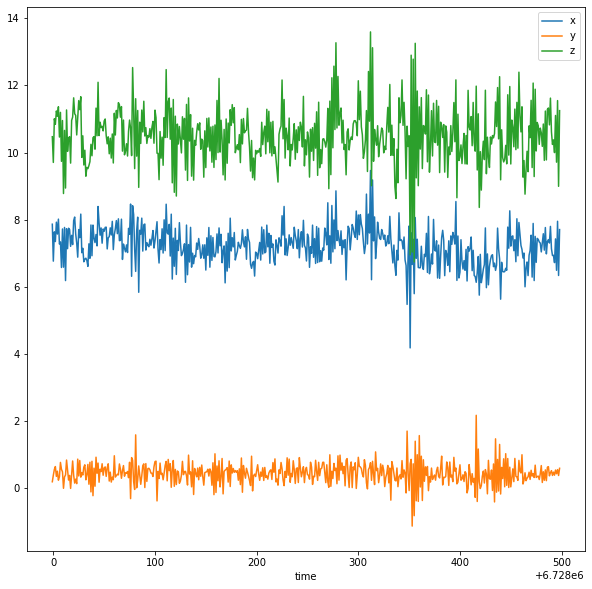

In [13]:
do_pca(rot_data["car_1"].iloc[1500:2000]).plot()

## Bike

<AxesSubplot:xlabel='time'>

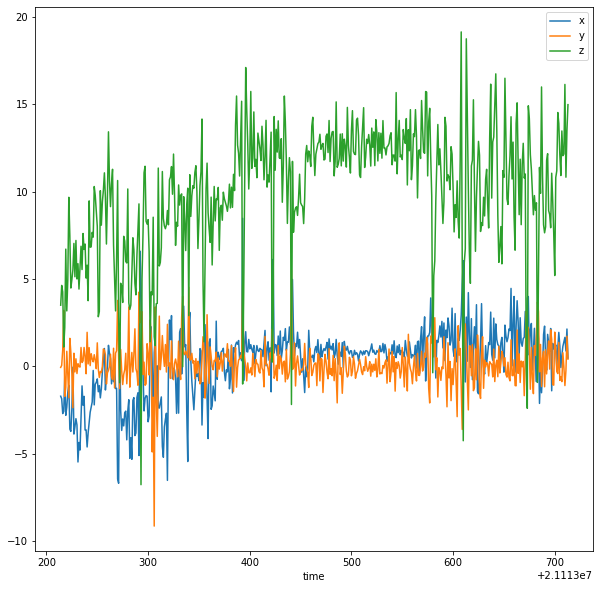

In [14]:
do_pca(rot_data["bike_2"].iloc[1500:2000]).plot()

## Walk

<AxesSubplot:xlabel='time'>

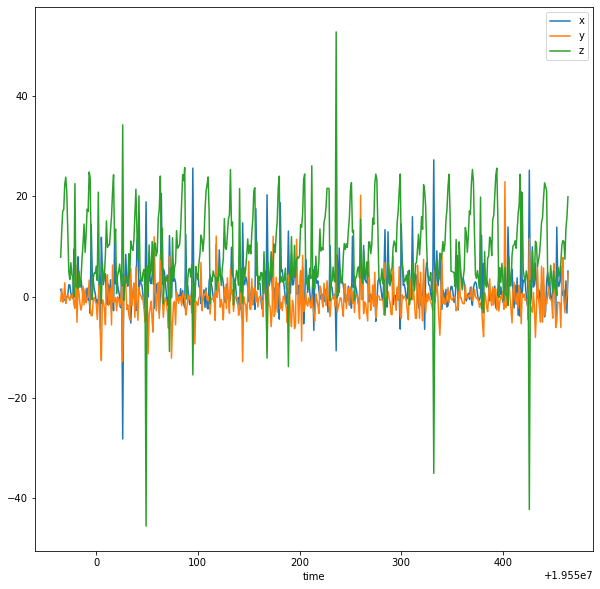

In [15]:
do_pca(rot_data["walk_1"].iloc[1500:2000]).plot()

In [32]:
nn_train = []
nn_test = []
for i, key in enumerate(rot_data):
    print(f"{i+1}/{len(rot_data)}")
    feat = get_features(rot_data[key])
    if "bike_2" in key: 
        nn_train += (chunk(rot_data[key], key.split("_")[0]))
    elif "bike_1" in key:
        nn_test += (chunk(rot_data[key], key.split("_")[0]))
    else:
        split = int(len(rot_data[key])*.7)
        nn_train += (chunk(rot_data[key].iloc[:split], key.split("_")[0]))
        nn_test += (chunk(rot_data[key].iloc[split:], key.split("_")[0]))
        
        
    feat.to_csv(f"features/{key}.csv")

1/5
2/5
3/5
4/5
5/5


In [33]:
import pickle
with open("nn_test.pickle", "w+b") as f:
    pickle.dump(nn_test, f)    

with open("nn_train.pickle", "w+b") as f:
    pickle.dump(nn_train, f)